In [542]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
#pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , RandomizedSearchCV,KFold,RepeatedKFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder , LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import get_scorer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection  import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn import svm 
from sklearn.svm import LinearSVC
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.inspection import permutation_importance
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, RocCurveDisplay, DetCurveDisplay,PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
import math

In [551]:
df = pd.read_csv('train.csv')
# удалим пока строку,которая нам точно будет не нужна - это ID,модель нужна, чтобы выбросить дубликаты и потом можно тоже убрать
df = df.drop(columns=['ID'])
df.head()

,Brand,Model,Year_of_production,Type,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box,Drive_wheels,Doors,Color,Airbags,Tax,Price
0,OPEL,Combo,2003,Goods wagon,No,Diesel,1.7,152000 km,4.0,Manual,Front,04-May,Grey,2,1438,9408
1,MERCEDES-BENZ,Vito,2008,Minivan,No,Diesel,2.2 Turbo,198700 km,4.0,Manual,Rear,02-Mar,White,6,1195,17000
2,TOYOTA,CHR,2018,Jeep,No,Petrol,2,37214 km,4.0,Automatic,Front,04-May,Grey,10,1079,36065
3,HYUNDAI,Grandeur,2012,Sedan,Yes,Petrol,3,137235 km,4.0,Automatic,Front,04-May,Silver,4,919,15524
4,MERCEDES-BENZ,ML 350,2015,Jeep,Yes,Diesel,3.5,79080 km,6.0,Automatic,4x4,04-May,Grey,12,1273,22894


,Year_of_production,Cylinders,Airbags,Tax,Price
Year_of_production,NaN,NaN,NaN,NaN,NaN
Cylinders,-0.107356,NaN,NaN,NaN,NaN
Airbags,0.052521,0.156152,NaN,NaN,NaN
Tax,-0.186570,0.598225,0.091656,NaN,NaN
Price,0.389336,0.108831,-0.129934,0.164458,NaN


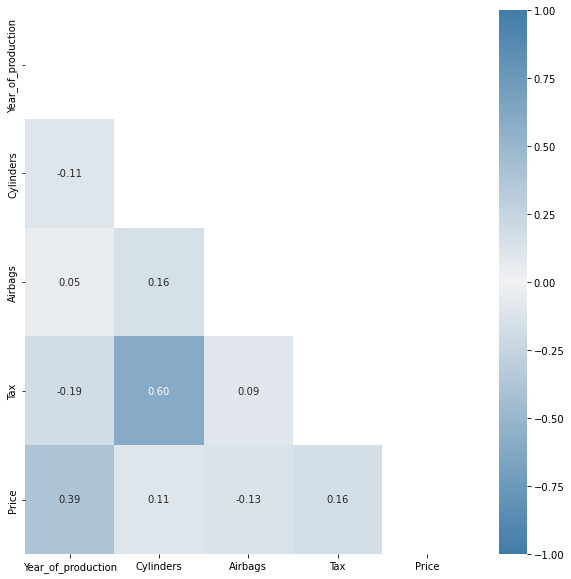

In [434]:
plt.figure(figsize=(10,10))

corr_matrix = df.corr()
mask = np.tril(corr_matrix, k = -1).astype(bool)
display(corr_matrix.where(mask))

mymap = sns.diverging_palette(240, 240, as_cmap = True)
sns.heatmap(corr_matrix.where(mask), vmin = -1, vmax = 1,
            annot=True, fmt='.2f', center=0, cmap=mymap);

### Тут идет обработка сета в одном блоке(собрал все манипуляции с файла 2 БЛОКА)

In [544]:
# Функции для обработки колонок с буквами, а также для их разделения
def volume(s):
    if len(s) <= 3:
        a = s
    else:
        a = s[:3]
    return a;

def turbo(df):
    b = []
    for i in range(len(df)):
        if df['Engine_volume'][i][4:] == 'Turbo':
            b.append(1)    
        else:
            b.append(0)
    return pd.Series(b);
# Делаю новую колонку Турбо, чтобы выделять машины с турбированным двигателем
# а также разделяю пробег от километров и делаю из этого целые числа
df['Turbo'] = 0
df['Turbo'] = turbo(df)
df['Engine_volume'] = [volume(i) for i in df['Engine_volume']]
df['Engine_volume'] = df['Engine_volume'].astype(float)
df.Mileage = [int(''.join(filter(str.isdigit, i ))) for i in df.Mileage]

# Ниже буду выбрасывать выброс, которые нашел по графикам
ind = df[df['Engine_volume'] == 0].index
# это некорректные данные, поэтому удаляем их
df = df.drop(index=ind)
inde = df[df['Engine_volume'] == 20].index
df = df.drop(index=inde)
df.Mileage.nlargest(15)
# если загуглить, то можно увидеть, что можно прочитать
# Книги рекордов Гиннеса цифра – 3,2 миллиона миль (5 149 900 км) – датируется маем 2013 года.
# логично, что все пробеги ниже этого очень большого числа подходят под условия
# убираем это большьшое число(удаляем по индексу)
df = df.drop(index = 3169)
# 0 пробег у авто 2010-х годов это очень странно, что на них вообще нет пробега
ind = df[df['Mileage'] == 0].index
df = df.drop(index=ind)
#display(df[df.duplicated()])
# есть дубликаты, поэтому убираем дубликаты
#display(df[df.duplicated()].head(60))
df_duplicates = df.drop('Price', axis = 1)
dupl_rows = df_duplicates[df_duplicates.duplicated()].index
df = df.drop(index=dupl_rows)
df = df.drop_duplicates(keep = 'first')
# удаляем модель, тк эта переменная нам больше не нужна, есть бренд
df = df.drop(columns=['Model'])
#display(df[df['Year_of_production'] < 1999].Price)
# Машина за почти за 50000 1995 года будет довольно сильно колебать мое обучение, поэтому считаю выбросом 
# и выбрасываю ее
df = df.drop(index=7146)
df = df[df['Year_of_production'] > 1965]


In [545]:
cat_features = ['Brand','Type','Color']
num_features = ['Year_of_production','Mileage','Tax']
y = np.array(df.Price)
X = df.drop(columns=['Price'])
# записаны переменные по порядку
columns = ['Brand','Type','Color','Fuel_type','Gear_box','Drive_wheels','Year_of_production','Mileage','Tax','Leather_interior','Doors','Engine_volume','Cylinders','Airbags','Turbo']

In [546]:
fuel_type_map = [{
    'col':'Fuel_type', 
    'mapping':{'Diesel':3,'Petrol':2,'Hybrid':1,'LPG':0}
    }]
gear_box_map = [{
    'col':'Gear_box',
    'mapping':{'Tiptronic':3,'Automatic':2,'Variator':1,'Manual':0}
    }]
drive_wheels_map = [{
    'col':'Drive_wheels',
    'mapping':{'4x4':2,'Rear':1,'Front':0}
    }]
doors_map = [{
    'col':'Doors',
    'mapping':{'04-May':2,'>5':1,'02-Mar':0}
    }]
leather_interior_map = [{
    'col':'Leather_interior',
    'mapping':{'Yes':1,'No':0}
    }]

fuel_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = fuel_type_map))])

gear_box_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = gear_box_map))])

drive_wheels_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = drive_wheels_map))])

doors_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = doors_map))])

leather_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = leather_interior_map))])

   
# для деревьев можно не стандартизировать данные в фичах 
CT = ColumnTransformer(transformers=[('cat',OrdinalEncoder(),cat_features),
                                     ('fuel_type', fuel_transformer, ['Fuel_type']),
                                     ('gear_box', gear_box_transformer, ['Gear_box']),
                                     ('drive_wheels', drive_wheels_transformer, ['Drive_wheels']),
                                     ('num','passthrough',num_features),
                                     ('leather',leather_transformer,['Leather_interior']),
                                     ('doors', doors_transformer, ['Doors'])],
                                      remainder = 'passthrough')

display(CT)

X_CT = CT.fit_transform(X)#.toarray()
X_CT = pd.DataFrame(X_CT,columns=columns)
X_CT.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OrdinalEncoder(),
                                 ['Brand', 'Type', 'Color']),
                                ('fuel_type',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Fuel_type',
                                                                           'mapping': {'Diesel': 3,
                                                                                       'Hybrid': 1,
                                                                                       'LPG': 0,
                                                                                       'Petrol': 2}}]))]),
                                 ['Fuel_type']),
                                ('gear_box',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Gear_box',
                                                                           'mapping': {'Auto...
                                                                                       'Rear': 1}}]))]),
                                 ['Drive_wheels']),
                                ('num', 'passthrough',
                                 ['Year_of_production', 'Mileage', 'Tax']),
                                ('leather',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Leather_interior',
                                                                           'mapping': {'No': 0,
                                                                                       'Yes': 1}}]))]),
                                 ['Leather_interior']),
                                ('doors',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Doors',
                                                                           'mapping': {'02-Mar': 0,
                                                                                       '04-May': 2,
                                                                                       '>5': 1}}]))]),
                                 ['Doors'])])

,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Turbo
0,31.0,2.0,7.0,3.0,0.0,0.0,2003.0,152000.0,1438.0,0.0,2.0,1.7,4.0,2.0,0.0
1,26.0,6.0,14.0,3.0,0.0,1.0,2008.0,198700.0,1195.0,0.0,0.0,2.2,4.0,6.0,1.0
2,39.0,4.0,7.0,2.0,2.0,0.0,2018.0,37214.0,1079.0,0.0,2.0,2.0,4.0,10.0,0.0
3,16.0,8.0,12.0,2.0,2.0,0.0,2012.0,137235.0,919.0,1.0,2.0,3.0,4.0,4.0,0.0
4,26.0,4.0,7.0,3.0,2.0,2.0,2015.0,79080.0,1273.0,1.0,2.0,3.5,6.0,12.0,0.0


In [550]:
### Преобразование этих переменных делается в этом файле, поэтому в файле с моделью этого нет
### в файле с аномалиями есть это уже есть
### преобразование не стал делать отдельным файлом и где то сбоку, тк я сделал 2 проверки для разных преобразований 
### и выбрал лучший по показателям, поэтому сразу оставил один из них

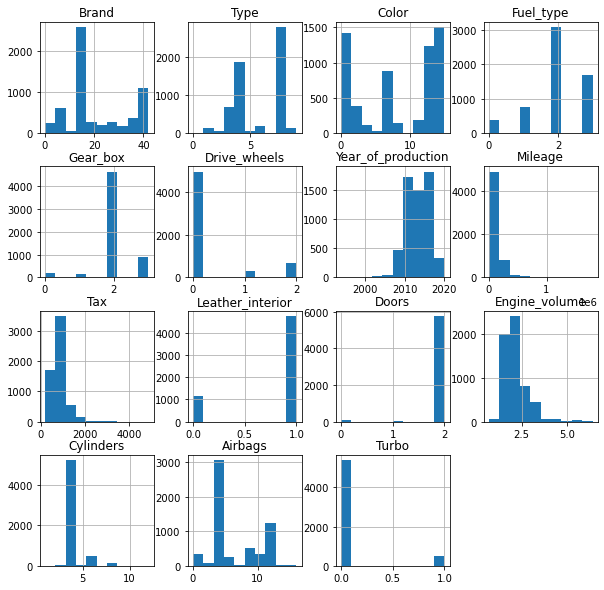

In [463]:
X_CT.hist(figsize=(10, 10));
# можно сделать преобразования пробега и налогов - перевести их к виду норм распределения
# тк данные не отрицателньые и все хорошо, можно сначала накинуть минмакс и потом Бокса-Кокса

In [547]:
# возьму преобразование Бокса-Кокса для пробег и налога
# преобраазуем переменные пробег и налог
power = PowerTransformer(method='box-cox') 
minmax = MinMaxScaler()

mile = power.fit_transform(minmax.fit_transform(pd.DataFrame(X_CT.Mileage)) + 1)
tax = power.fit_transform(minmax.fit_transform(pd.DataFrame(X_CT.Tax)) + 1)


X_CT.Mileage = mile
X_CT.Tax = tax
#преобразовываю данные и записываю в колонки моего Х после трансформера

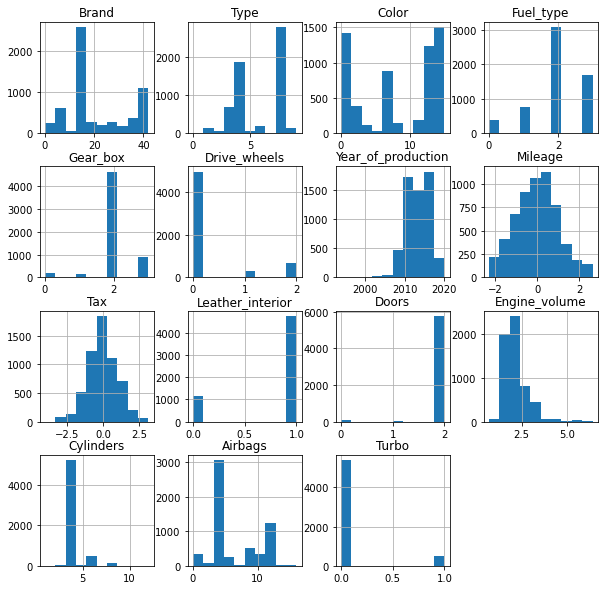

In [454]:
X_CT.hist(figsize=(10, 10));

In [ ]:
# почему выбрал Бокса-Кокса?
# При фиксированном random_state преобразования Бокса-Кокса с минмакс скалером дает лучший результа для Х
# Йео-Джонсона
#R2 0.7283640383587571
#MSE 57097448.2959105
#MAPE 0.29684660109343364

# Бокс-Кокс вместе с minmax scaler
#R2 0.7284290139762317
#MSE 57083790.52417497
#MAPE 0.2967913123229752

# Да, разница не большая, но заметная, поэтому и выбираю лучшее преобразование

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X_CT, y, test_size= 0.25)

In [230]:
# беру отобранную модель в файле Models и буду у нее отбирать наиболее важные признаки
# и незначимые выбрасывать и смотреть на результат

In [549]:
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.7283639155984106
MSE 57097474.0999406
MAPE 0.29684677263212866


In [ ]:
# также далее посмотрим на значимость признаков наших моделей и отбросим самые неинформативные

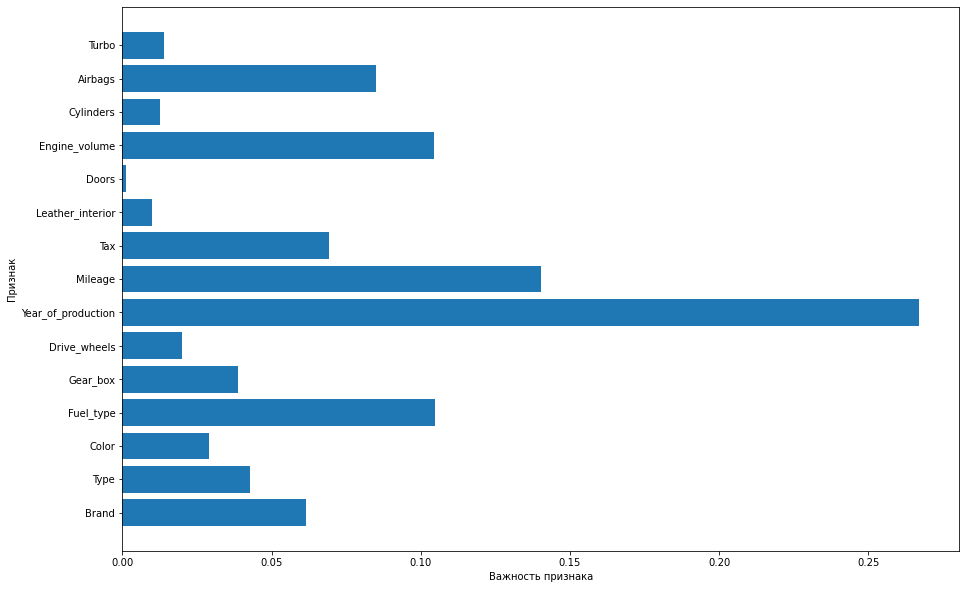

In [429]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features),pd.DataFrame(X_train).columns) 
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
plt.figure(figsize = (15, 10))
plot_feature_importances(estimator)

# можно отметить, что большую важность признаков для лесов нам дают признаки больше 0.6 где то
# сразу можно отметить переменнуб Doors, которая дает нам около 0 значимости
# посмотрим этотже график, только с помощью дополнительной графика ниже основного, который показывает значимость цветом

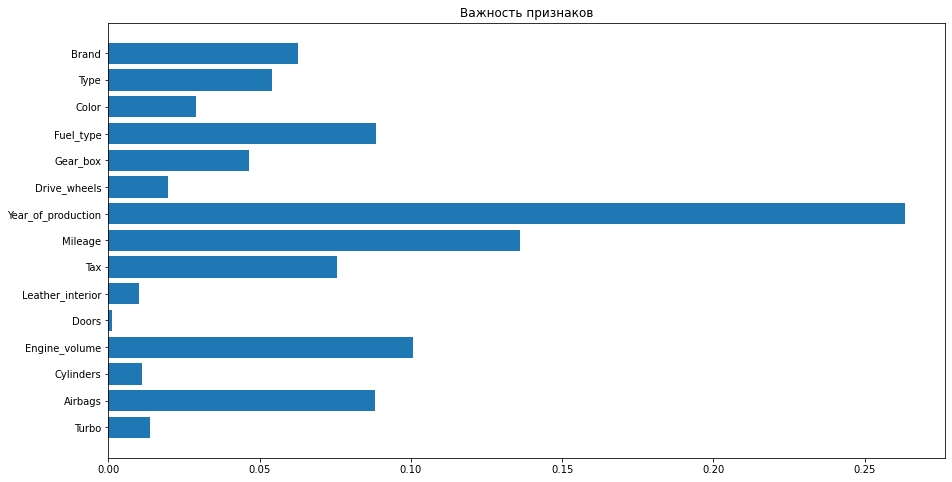

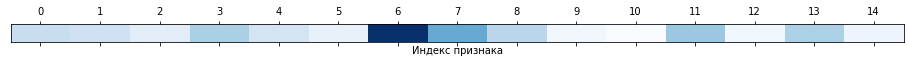

In [213]:
# создаем необходимый граф для построения дополнительной оси со значимостью
importance = estimator.feature_importances_
feature_names = X_CT.columns # тут не важно X_CT или X_train, тк у них одинаковые переменные

plt.figure(figsize=(15,8))
plt.barh(width=importance, y = feature_names)
plt.gca().invert_yaxis()
plt.title("Важность признаков")
plt.show()

mask = importance
plt.matshow( mask.reshape(1,-1), cmap = 'Blues', aspect=0.3)
plt.yticks([])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");

#как мы видим, здесь показаны те же самые фичи с усилением цвета для важности этого признака
# как видно из графика - Doors имеют очень маленькую значимость, тк он по цвету идет полнстью белым
# следовательно можно выбросить, тк переменная не несет конкретной информации
# из малоинформативных можно выделить еще Leather_interior и Turbo

,mean,std
Doors,0.000951,0.001030
Cylinders,0.009903,0.005954
Leather_interior,0.010160,0.004462


,mean,std
Airbags,0.082342,0.018167
Engine_volume,0.097104,0.015121
Fuel_type,0.099436,0.029032
Mileage,0.138112,0.017091
Year_of_production,0.265405,0.020223


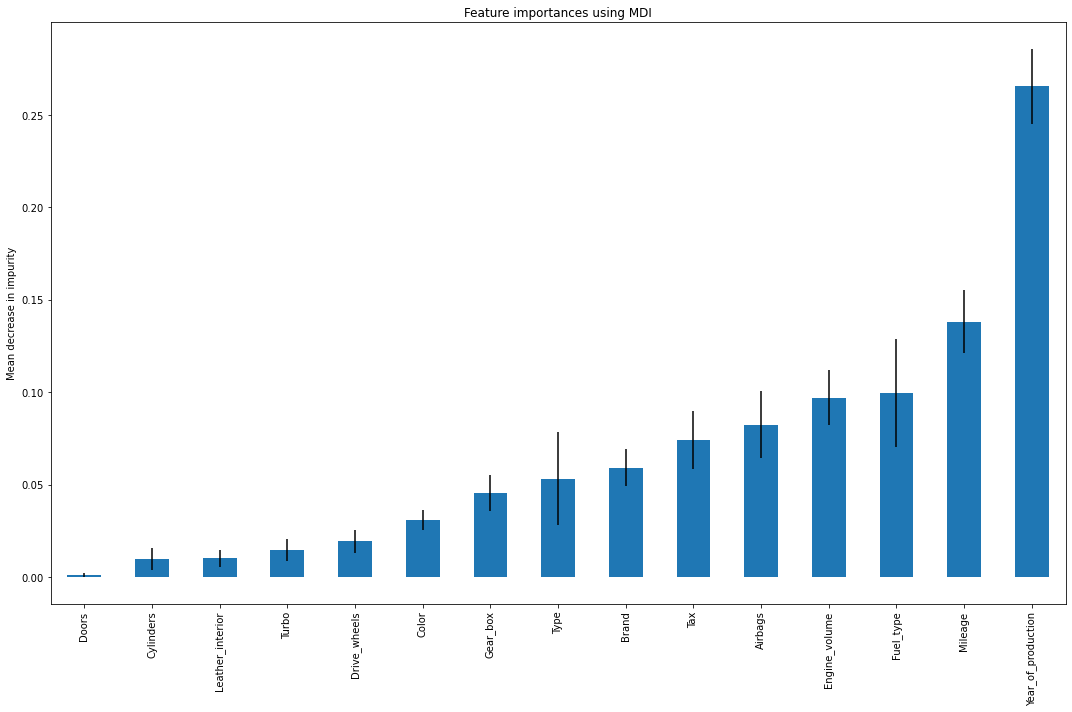

In [15]:
# теперь посмотрим на наши переменные и выведем 5 наиболее важных

feature_names = X_CT.columns
forest_importances = pd.DataFrame(estimator.feature_importances_, index=feature_names, columns =['mean'])
forest_importances['std'] = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)

sort_forest = forest_importances.sort_values(by='mean')


fig, ax = plt.subplots(figsize=(15,10))
col = sort_forest['mean']
yerr = sort_forest['std']
col.plot.bar(yerr=yerr, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# выведу 3 наиболее "слабые" фичи и 5 наиболее "сильных"
display(sort_forest.head(3))
display(sort_forest.tail(5))


# как и видно было на графике, Doors,Leather_interior,Cylinders малозначимые
# (можно будет посмотреть комбинации их дропа)
# еще я бы отметил сюда Turbo, ну это посмотрим как раз таки позже

# как и видно на графике выше, все 5 фич с наибольшей значимостью отражаются и здесь
# проведем дальше анализ


In [ ]:
# примерно мы увидели картину по нашим фичам и давайте пройдемся рекурсивными методами для отбора переменных

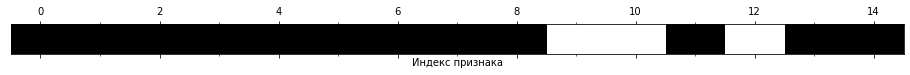

In [28]:
rfe_select = RFE(RandomForestRegressor(n_estimators=3500, random_state=42),
             n_features_to_select = 12)

rfe_select.fit(X_train, y_train)
# визуализируем отобранные признаки:
mask = rfe_select.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.xlabel("Индекс признака");
# при отборе 14 фич = выкидывает 10 фичу = Doors
# можно пробежаться 2-3 раза до 12 фич и посмотреть какие будут обозначаться белым
# при отборе 13 фич = выкидывает 10 и 12   = Doors and cylinders
# при отборе 12 фич = выкидывает 10,12,9  = Doors and cylinders and Leather_interior
# то есть можно сделать вывод о том, что они не будут сильно влиять на модель и создавают шум

In [33]:
from sklearn.feature_selection import SelectPercentile


In [71]:
# отбор переменных с помощью шума

# задаем определенное стартовое значение для воспроизводимости результата
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(X_CT),25))
# добавляем к данным шумовые признаки
# первые 14 признаков являются исходными, остальные являются шумовыми
X_w_noise = np.hstack([X_CT, noise])

X_train_nw, X_test_nw, y_train_nw, y_test_nw = train_test_split(X_w_noise, y, test_size=.25)
select_pct = SelectPercentile(percentile=50)
select_pct.fit(X_train_nw, y_train_nw)
# преобразовываем обучающий набор
X_train_selected = select_pct.transform(X_train_nw)

print("форма массива X_train: {}".format(X_train.shape))
print("форма массива X_train_selected: {}".format(X_train_selected.shape))

форма массива X_train: (4423, 15)
форма массива X_train_selected: (4423, 20)


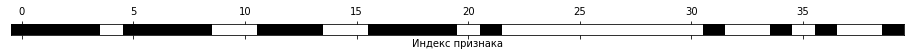

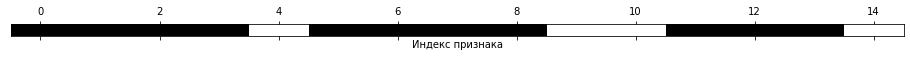

In [73]:
mask = select_pct.get_support()
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.5)
plt.yticks([])
plt.xlabel("Индекс признака");

mask = select_pct.get_support()[:15]
plt.matshow( mask.reshape(1,-1), cmap = 'gray_r', aspect=0.2)
plt.yticks([])
plt.xlabel("Индекс признака");

# отбор признаков с шумом нам выдает 4-9-10-14 - (Doors and Gear_Box and Leather_interior and Turbo)
# это тоже надо будет приметить и проверить

In [ ]:
## Проверка удаления признаков из нашего фрейма для выбранной модели

In [214]:
X_CT = pd.DataFrame(X_CT,columns=columns)
X_CT.head()

,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Turbo
0,31.0,2.0,7.0,3.0,0.0,0.0,-2.50,0.491120,2.289116,0.0,2.0,1.7,4.0,2.0,0.0
1,26.0,6.0,14.0,3.0,0.0,1.0,-1.25,1.000794,1.462585,0.0,0.0,2.2,4.0,6.0,1.0
2,39.0,4.0,7.0,2.0,2.0,0.0,1.25,-0.761629,1.068027,0.0,2.0,2.0,4.0,10.0,0.0
3,16.0,8.0,12.0,2.0,2.0,0.0,-0.25,0.329978,0.523810,1.0,2.0,3.0,4.0,4.0,0.0
4,26.0,4.0,7.0,3.0,2.0,2.0,0.50,-0.304713,1.727891,1.0,2.0,3.5,6.0,12.0,0.0


In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_CT, y, test_size= 0.25)

In [ ]:
# переменные, которые выбрал с помощью значимости для модели(малоинформативные)
# 'Doors','Cylinders','Turbo','Leather_interior','Gear_Box'
# но еще посмотрим на корреляц матрицу и увидим что с чем сильно коррелирует

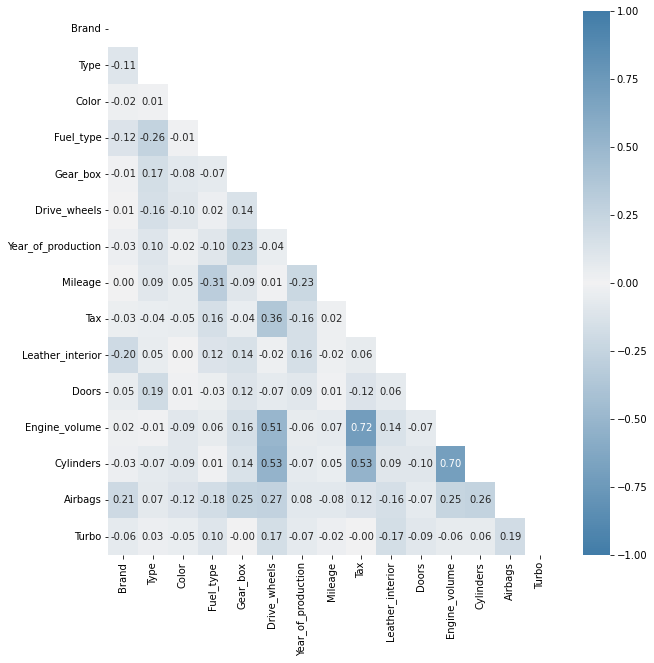

In [216]:
plt.figure(figsize=(10,10))

corr_matrix = X_CT.corr()
mask = np.tril(corr_matrix, k = -1).astype(bool)
#display(corr_matrix.where(mask))

mymap = sns.diverging_palette(240, 240, as_cmap = True)

sns.heatmap(corr_matrix.where(mask), vmin = -1, vmax = 1,
            annot=True, fmt='.2f', center=0, cmap=mymap);

### Модель без удаления переменных

In [290]:
X_CT = pd.DataFrame(X_CT,columns=columns)

In [476]:
X_train, X_test, y_train, y_test = train_test_split(X_CT, y, test_size= 0.25)

In [269]:
# Модель без удаления переменных
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.7055880950900757
MSE 61872392.09548647
MAPE 0.3231177217727365


### Модель с удалением Doors, Cylinders, Leather_interior

In [488]:
X_CT = pd.DataFrame(X_CT,columns=columns)
X_1 = X_CT.drop(columns=['Doors','Cylinders','Leather_interior'])

In [491]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size= 0.25)

In [492]:
# Модель с удалением 'Doors','Cylinders','Leather_interior'
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))
# если брать модели с удалением, то эта будет самая оптимальная поскольку везде слишком сильно начинает расти ошибка
# убираю самые неинорфмативные столбцы, которые в данном примере

R2 0.7379190363604327
MSE 56876006.079035334
MAPE 0.34287217675443216


### Модель с удалением Doors, Gear_Box, Leather_interior

In [85]:
X_CT = pd.DataFrame(X_CT,columns=columns)
X_2 = X_CT.drop(columns=['Doors','Gear_box','Leather_interior'])

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size= 0.25)

In [88]:
# Модель без удаления переменных 'Doors','Gear_box','Leather_interior'
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))
# Gear_box на некоторыех теста значимости оказался белым цветом, но по графикам важности он вносит весомый вклад
# поэтому его нельзя выбрасывать
# поэтому эту модель с удалением этих переменных можно не рассматривать

R2 0.700420809209696
MSE 64951717.112929106
MAPE 0.366269642207187


### Модель с удалением Doors, Turbo , Leather_interior 

In [94]:
X_CT = pd.DataFrame(X_CT,columns=columns)
X_3 = X_CT.drop(columns=['Doors','Turbo','Leather_interior'])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size= 0.25)

In [96]:
# Модель без удаления переменных 'Doors','Turbo','Leather_interior'
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.6773609979612003
MSE 65481487.788657434
MAPE 0.3424080377745553


### Модель с удалением Doors, Turbo , Leather_interior,Cylinders

In [142]:
X_CT = pd.DataFrame(X_CT,columns=columns)
X_4 = X_CT.drop(columns=['Doors','Turbo','Leather_interior','Cylinders'])

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_4, y, test_size= 0.25)

In [144]:
# Модель без удаления переменных 'Doors','Turbo','Leather_interior','Cylinders'
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.706024610596664
MSE 60391169.863469794
MAPE 0.3213678168748459


### После проведенного анализа c фичами, делаю вывод, что буду убирать следующие переменные ('Doors','Cylinders','Leather_interior'), тк у модели меньшая ошибка и большая обьясняемость нашей задачи при выбросе этих переменных => в фрейм буду использовать все остальные переменные, кроме этих